## 3.0 CNN Genre Classification

This notebook continues with supervised learning using the generated spectorgrams to do genre classification and prediction.

### Table of Contents
[3.1. Setup](#1.)<br>
[3.1.1 Loading libraries](#1.1)<br>
[3.1.2 Setting data directories](#1.2)<br>
[3.1.3 Defining functions](#1.3)<br>
[3.1.4 Reading in train, validation, and test data sets](#1.4)<br>

[3.2. Two Layer Convolutional Neural Network](#2.)<br>
[3.2.1 CNN setup](#2.1)<br>
[3.2.2 2D CNN](#2.2)<br>
[3.2.3 1D CNN](#2.3)<br>

[3.3. Deep Convolutional Neural Network](#3.)<br>
[3.3.1 6 layer 2D CNN](#3.1)<br>


### 3.1. Setup <a class="anchor" id="1."></a>

#### 3.1.1 Loading libraries <a class="anchor" id="1.1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

import timeit
import datetime

from sklearn import preprocessing

#### 3.1.2 Setting data directories <a class="anchor" id="1.2"></a>

In [2]:
ds_description = '5x10s'
# Set the directory for the spectrograms
data_dir = f'./data/spect_subsample_{ds_description}_np'
print("Directory of spectrograms: {}".format(data_dir))

Directory of spectrograms: ./data/spect_subsample_5x10s_np


In [3]:
genre_dict = {0 : 'Hip-Hop',
              1 : 'Pop',
              2 : 'Folk',
              3 : 'Experimental',
              4 : 'Rock',
              5 : 'International',
              6 : 'Electronic',
              7 : 'Instrumental'}

#### 3.1.3 Defining functions <a class="anchor" id="1.3"></a>

In [4]:
def load_data(data_dir, ds_description, str_X, str_Y):
    '''
    Loads the .npy data files generated previously from the pre-processing ipynb
    Note: .npy files need to be in the format: train_spect_{ds_description}_np.npy
    
    Inputs
    ------
    data_dir: directory of the .npy files
    ds_description: e.g. '5x10s'  5 subsamples of 10s length
    str_X: str name of the 'X' data, either: 'spect' or 'X'
    str_Y: str name of the 'Y' data, either: 'labels' or 'Y'
    
    Returns
    -------
    6 numpy arrays of:
        train_{str_X}, train_{str_Y}, val_{str_X}, val_{str_Y}, test_{str_X}, test_{str_Y}
    '''
    assert (str_X in ['spect','X']), "Assertion Error, str_X must be either 'spect' or 'X'."
    assert (str_Y in ['labels','Y']), "Assertion Error, str_Y must be either 'labels' or 'Y'."
    
    print("Loading .npy data files...")
    # Start timer
    start_time = timeit.default_timer()

    train_str_X = np.load(f'{data_dir}/train_{str_X}_{ds_description}_np.npy')
    val_str_X = np.load(f'{data_dir}/val_{str_X}_{ds_description}_np.npy')
    test_str_X = np.load(f'{data_dir}/test_{str_X}_{ds_description}_np.npy')

    train_str_Y = np.load(f'{data_dir}/train_{str_Y}_{ds_description}_np.npy')
    val_str_Y = np.load(f'{data_dir}/val_{str_Y}_{ds_description}_np.npy')
    test_str_Y = np.load(f'{data_dir}/test_{str_Y}_{ds_description}_np.npy')
    
    elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
    print("", end='\n')
    print("Total processing time (h:mm:ss): {}".format(elapsed[:-7]))
    print("\nLoaded .npy data files, verifying shape of saved data...")
    print(f"Shape of 'train_{str_X}':", train_str_X.shape)
    print(f"Shape of 'train_{str_Y}':", train_str_Y.shape)

    print(f"Shape of 'val_{str_X}':", val_str_X.shape)
    print(f"Shape of 'val_{str_Y}':", val_str_Y.shape)

    print(f"Shape of 'test_{str_X}':", test_str_X.shape)
    print(f"Shape of 'test_{str_Y}':", test_str_Y.shape)
    
    return train_str_X, train_str_Y, val_str_X, val_str_Y, test_str_X, test_str_Y


def mkdir_p(mypath):
    '''
    Creates a directory. equivalent to using mkdir -p on the command line
    '''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: 
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

#### 3.1.4 Reading in train, validation, and test data sets <a class="anchor" id="1.4"></a>

In [5]:
# Read in the spectrogram and labels data from the .npy files
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_data(
    data_dir, ds_description, 'X', 'Y')

Loading .npy data files...

Total processing time (h:mm:ss): 0:01:26

Loaded .npy data files, verifying shape of saved data...
Shape of 'train_X': (31970, 431, 128)
Shape of 'train_Y': (31970, 8)
Shape of 'val_X': (4000, 431, 128)
Shape of 'val_Y': (4000, 8)
Shape of 'test_X': (4000, 431, 128)
Shape of 'test_Y': (4000, 8)


### 3.2. Two Layer Convolutional Neural Network <a class="anchor" id="2."></a>

#### 3.2.1 CNN setup <a class="anchor" id="2.1"></a>

In [6]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, CuDNNLSTM, Dropout, Activation, CuDNNGRU
from keras.layers import Conv1D, Conv2D, concatenate, MaxPooling1D, MaxPooling2D, Flatten, Embedding, Lambda

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers

from os.path import isfile

C:\Users\kw.UNLOVEDPC\Anaconda3\envs\py3gpu-Env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
def show_summary_stats(history, model_name):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(f'{model_name} model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

#### 3.2.2 2D CNN <a class="anchor" id="2.2"></a>

In [41]:
model_name = 'cnn2D_14'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'kernel_size1' : (5,5),
      'kernel_size2' : (3,3),
      'filter_size1' : 8,
      'filter_size2' : 32,
      'strides1' : 2,
      'strides2' : 2,
      'padding' : 'same',
      'activation' : 'relu',
      'pool_size1' : 2,
      'pool_size2' : 2,
      'l2' : 0.01,
      'epochs' : 12,
      'optimizer' : 'adam',
      'dense1' : 32,
      'dense2' : 16,
      'dropout1' : 0.2
     }
num_classes = len(genre_dict)

# Adding additional dimension for Conv2D
train_X1 = np.expand_dims(train_X, axis = -1)
val_X1 = np.expand_dims(val_X, axis = -1)

# Building the model
K.clear_session()
model = Sequential()

model.add(Conv2D(filters=hp['filter_size1'], kernel_size=hp['kernel_size1'], 
                 strides=hp['strides1'], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']),
                 input_shape=train_X1.shape[1:]
                ))
model.add(MaxPooling2D(pool_size=hp['pool_size1']))

model.add(Conv2D(filters=hp['filter_size2'], kernel_size=hp['kernel_size2'], 
                 strides=hp['strides2'], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))
model.add(MaxPooling2D(pool_size=hp['pool_size2']))

model.add(Flatten())

model.add(Dense(hp['dense1'], activation='relu'))
model.add(Dropout(hp['dropout1']))
model.add(Dense(hp['dense2'], activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Complie the model
model.compile(
            loss='categorical_crossentropy',
            optimizer=hp['optimizer'],
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X1, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X1, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/cnn2D_14
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 216, 64, 8)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 108, 32, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 16, 32)        2336      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 8, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6912)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                221216    
_________________________________________________________________
dropout_1 (Drop

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


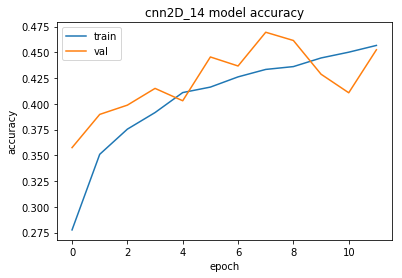

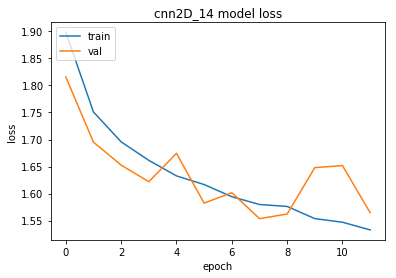

In [42]:
show_summary_stats(history, model_name)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


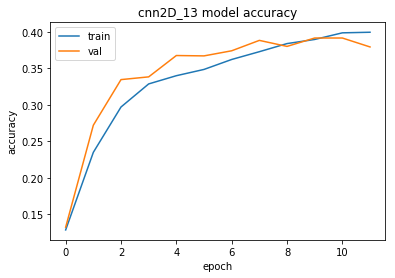

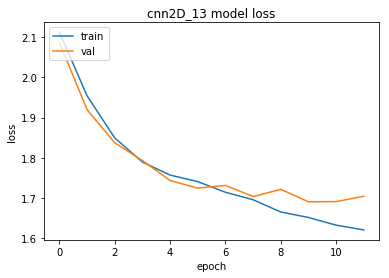

In [40]:
show_summary_stats(history, model_name)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


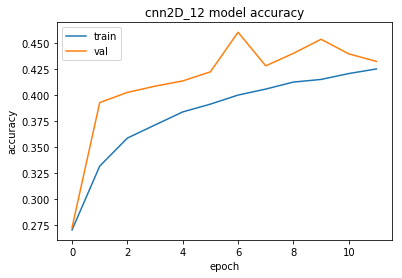

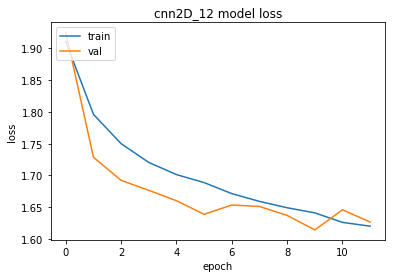

In [45]:
show_summary_stats(history, model_name)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


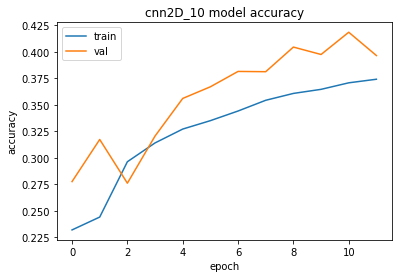

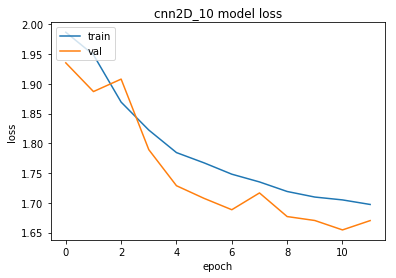

In [39]:
show_summary_stats(history, model_name)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


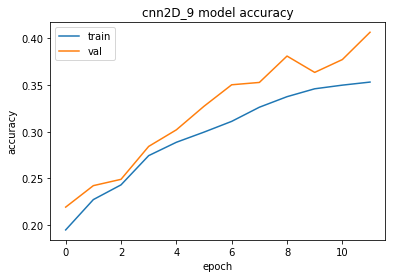

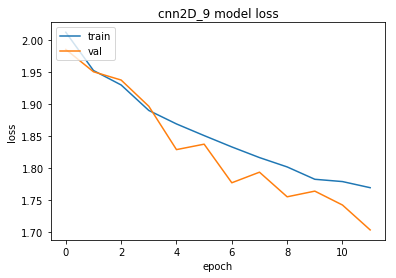

In [36]:
show_summary_stats(history, model_name)

#### 3.2.3 1D CNN <a class="anchor" id="2.3"></a>

In [34]:
model_name = 'cnn1D_22'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'kernel_size1' : 3,
      'kernel_size2' : 5,
      'filter_size1' : 128,
      'filter_size2' : 256,
      'strides1' : 1,
      'strides2' : 2,
      'padding' : 'valid',
      'activation' : 'relu',
      'pool_size1' : 1,
      'pool_size2' : 3,
      'l2' : 0.01,
      'epochs' : 12,
      'optimizer' : 'adam',
      'dense1' : 32,
      'dense2' : 16,
      'dropout1' : 0.2
     }
num_classes = len(genre_dict)

# Building the model
K.clear_session()
model = Sequential()
model.add(Conv1D(filters=hp['filter_size1'], kernel_size=hp['kernel_size1'], 
                 strides=hp['strides1'], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']),
                 input_shape=train_X.shape[1:]
                ))
model.add(MaxPooling1D(pool_size=hp['pool_size1']))

model.add(Conv1D(filters=hp['filter_size2'], kernel_size=hp['kernel_size2'], 
                 strides=hp['strides2'], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))
model.add(MaxPooling1D(pool_size=hp['pool_size2']))

model.add(Flatten())

model.add(Dense(hp['dense1'], activation='relu'))
model.add(Dropout(hp['dropout1']))
model.add(Dense(hp['dense2'], activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Complie the model
model.compile(
            loss='categorical_crossentropy',
            optimizer=hp['optimizer'],
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X, val_Y), verbose=1, callbacks=callbacks_list)
    

Directory of model parameters to be saved: ./models/cnn1D_22
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 429, 128)          49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 429, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 213, 256)          164096    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 71, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                581664    
_________________________________________________________________
dropout_1 (Drop

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


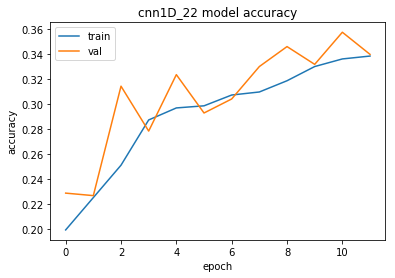

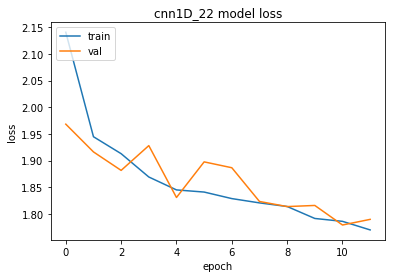

In [35]:
show_summary_stats(history, model_name)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


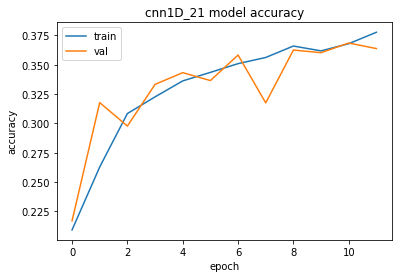

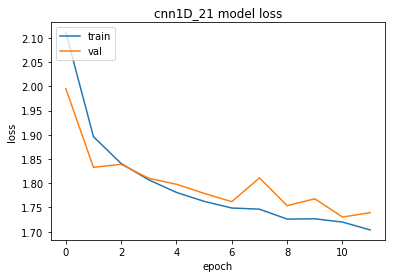

In [26]:
show_summary_stats(history, model_name)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


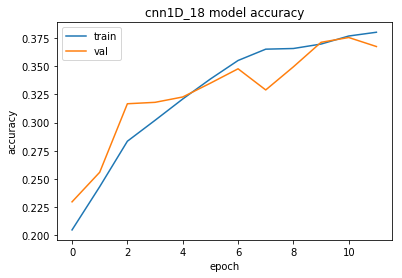

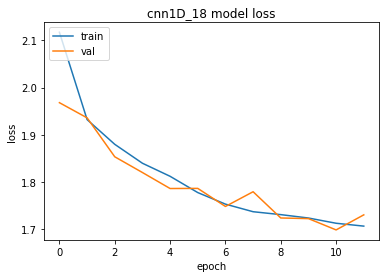

In [16]:
show_summary_stats(history, model_name)

### 3.3. Deep Convolutional Neural Network <a class="anchor" id="3."></a>

#### 3.3.1 CNN Setup <a class="anchor" id="3.1"></a>

In [6]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, CuDNNLSTM, Dropout, Activation, CuDNNGRU
from keras.layers import Conv1D, Conv2D, concatenate, MaxPooling1D, MaxPooling2D, Flatten, Embedding, Lambda

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers

from os.path import isfile

C:\Users\kw.UNLOVEDPC\Anaconda3\envs\py3gpu-Env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
def show_summary_stats(history, model_name):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(f'{model_name} model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

#### 3.3.2 Deep 6-Layer 2D CNN <a class="anchor" id="3.2"></a>

In [25]:
model_name = '6L_cnn2D_4'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'kernel_size' : [(5,5), (3,3), (3,3), (3,3), (3,3), (3,3)],
      'filter_size' : [   32,   32,    32,    32,    32,  32],
      'strides' :     [    1,     1,     1,     1,     1,     1],
      'padding' : 'same',
      'activation' : 'relu',
      'pool_size' :   [ 2, 2],
      'l2' : 0.01,
      'epochs' : 12,
      'optimizer' : 'adam',
      'dense' : [128, 32],
      'dropout1' : 0.2
     }
num_classes = len(genre_dict)

# Adding additional dimension for Conv2D
train_X1 = np.expand_dims(train_X, axis = -1)
val_X1 = np.expand_dims(val_X, axis = -1)

# Building the model
K.clear_session()
model = Sequential()

model.add(Conv2D(filters=hp['filter_size'][0], kernel_size=hp['kernel_size'][0], 
                 strides=hp['strides'][0], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']),
                 input_shape=train_X1.shape[1:]
                ))

model.add(MaxPooling2D(pool_size=hp['pool_size'][0]))

model.add(Conv2D(filters=hp['filter_size'][1], kernel_size=hp['kernel_size'][1], 
                 strides=hp['strides'][1], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(Conv2D(filters=hp['filter_size'][2], kernel_size=hp['kernel_size'][2], 
                 strides=hp['strides'][2], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(Conv2D(filters=hp['filter_size'][3], kernel_size=hp['kernel_size'][3], 
                 strides=hp['strides'][3], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(MaxPooling2D(pool_size=hp['pool_size'][1]))

model.add(Conv2D(filters=hp['filter_size'][4], kernel_size=hp['kernel_size'][4], 
                 strides=hp['strides'][4], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(Conv2D(filters=hp['filter_size'][5], kernel_size=hp['kernel_size'][5], 
                 strides=hp['strides'][5], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(Flatten())

model.add(Dense(hp['dense'][0], activation='relu'))
model.add(Dropout(hp['dropout1']))
model.add(Dense(hp['dense'][1], activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Complie the model
model.compile(
            loss='categorical_crossentropy',
            optimizer=hp['optimizer'],
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X1, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X1, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/6L_cnn2D_3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 431, 128, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 215, 64, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 215, 64, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 215, 64, 32)       9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 215, 64, 32)       9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 215, 64, 32)       9248      
_________________________________________________________________
conv2d_6 (Con

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


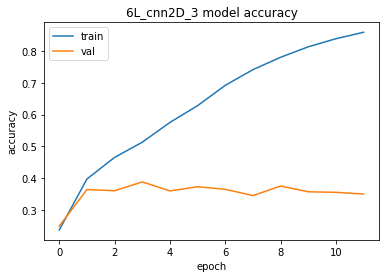

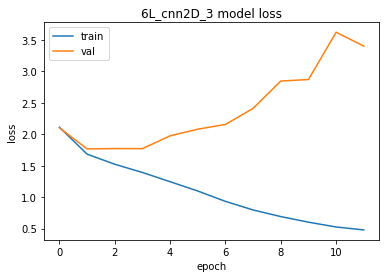

In [26]:
show_summary_stats(history, model_name)

In [27]:
model_name = '6L_cnn2D_4'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'kernel_size' : [(5,5), (3,3), (3,3), (3,3), (3,3), (3,3)],
      'filter_size' : [   32,   32,    32,    32,    32,  32],
      'strides' :     [    1,     1,     1,     1,     1,     1],
      'padding' : 'same',
      'activation' : 'relu',
      'pool_size' :   [ 2, 2],
      'l2' : 0.01,
      'epochs' : 12,
      'optimizer' : 'adam',
      'dense' : [128, 32],
      'dropout1' : 0.2
     }
num_classes = len(genre_dict)

# Adding additional dimension for Conv2D
train_X1 = np.expand_dims(train_X, axis = -1)
val_X1 = np.expand_dims(val_X, axis = -1)

# Building the model
K.clear_session()
model = Sequential()

model.add(Conv2D(filters=hp['filter_size'][0], kernel_size=hp['kernel_size'][0], 
                 strides=hp['strides'][0], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']),
                 input_shape=train_X1.shape[1:]
                ))

model.add(MaxPooling2D(pool_size=hp['pool_size'][0]))

model.add(Conv2D(filters=hp['filter_size'][1], kernel_size=hp['kernel_size'][1], 
                 strides=hp['strides'][1], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(Conv2D(filters=hp['filter_size'][2], kernel_size=hp['kernel_size'][2], 
                 strides=hp['strides'][2], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(Conv2D(filters=hp['filter_size'][3], kernel_size=hp['kernel_size'][3], 
                 strides=hp['strides'][3], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(MaxPooling2D(pool_size=hp['pool_size'][1]))

model.add(Conv2D(filters=hp['filter_size'][4], kernel_size=hp['kernel_size'][4], 
                 strides=hp['strides'][4], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(Conv2D(filters=hp['filter_size'][5], kernel_size=hp['kernel_size'][5], 
                 strides=hp['strides'][5], padding=hp['padding'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))

model.add(Flatten())

model.add(Dense(hp['dense'][0], activation='relu'))
model.add(Dropout(hp['dropout1']))
model.add(Dense(hp['dense'][1], activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Complie the model
model.compile(
            loss='categorical_crossentropy',
            optimizer=hp['optimizer'],
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X1, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X1, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/6L_cnn2D_4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 431, 128, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 215, 64, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 215, 64, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 215, 64, 32)       9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 215, 64, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 107, 32, 32)       0         
_________________________________________________________________
conv2d_5 (Con

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


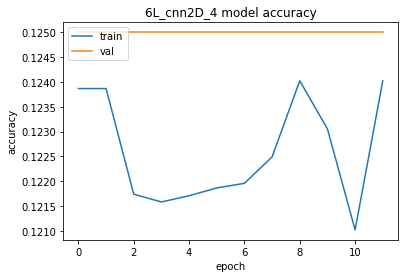

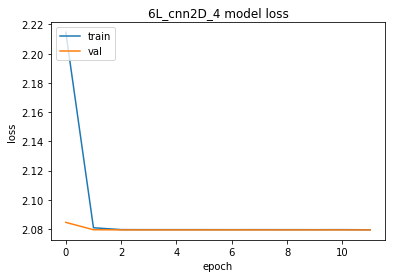

In [28]:
show_summary_stats(history, model_name)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


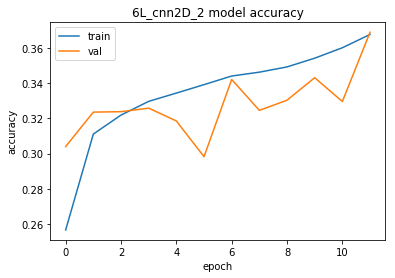

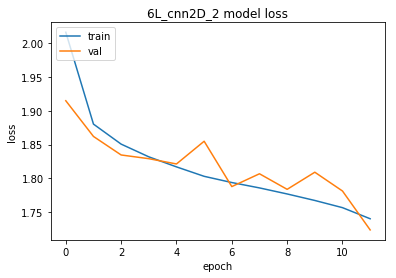

In [23]:
show_summary_stats(history, model_name)